# Price Model Data Exploration

This notebook first attempt to model allowed amounts

## Notebook Setup and Local Functions

### Install packages

In [1]:
#install h20 for modeling exploration, need to set this up on hub
!pip install h2o

### Import libraries

In [41]:
#basic math/stats/graphs libraries
import numpy as np
from numpy import sqrt, exp, log, mean
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from math import ceil, floor
from ipywidgets import Layout, Button, Box, FloatText, Textarea,Dropdown, Label, IntSlider, Checkbox, interact, interactive
sns.set_style("whitegrid")

In [3]:
#basic model/pandas libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from datetime import datetime
import h2o
from h2o.automl import H2OAutoML

In [4]:
#install snowflake connector
import sys 
#pull in snowflake login snippets
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


### Define functions

In [5]:
#generic function to pull in table from snowflake

def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"',
               select_statement=None, limit=None, where=None, 
               diag=False, sample_n=None):
    
    if select_statement is not None:
        sql=select_statement 
    
    else:
        sql = f"""select * 
         from {db}
        """ 
    if sample_n is not None:
        sql+=f""" sample row ({sample_n} rows) 
        """ 
    if where is not None:
        sql+=f""" where {where} 
        """
    if limit is not None:
        sql+=f""" limit {limit}
        """
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        print(sql)
        return sql

#function for summarizing data within snowflake
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['count','stddev','min', '1percentile', '5percentile',
                                      '10percentile','25percentile',
                                     'average','median','75percentile','90percentile',
                                      '95percentile','99percentile','max']):
    sql = f"""select 
        count(*) as count
        ,stddev({x}) as stddev
        ,min({x}::float) as min
        ,approx_percentile({x}::float,.01) as percentile_1
        ,approx_percentile({x}::float,.05) as percentile_5
        ,approx_percentile({x}::float,.1) as percentile_10
        ,approx_percentile({x}::float,.25) as percentile_25
        ,avg({x}::float) as average
        ,median({x}::float) as median
        ,approx_percentile({x}::float,.75) as percentile_75
        ,approx_percentile({x}::float,.9) as percentile_90
        ,approx_percentile({x}::float,.95) as percentile_95
        ,approx_percentile({x}::float,.99) as percentile_99
         ,max({x}::float) as max
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

In [21]:
def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    return current_time

### Define Databases

In [8]:
#encounters database
enc_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ENCOUNTERSMX_LS_GA"'

#allowed amounts database
aa_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ALLOWEDAMOUNTS_GA"'

#enhanced allowed amounts database (Jan, Feb 2020)
aa_enh_db='"SANDBOX_KRAO"."EDA"."ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.01% sample)
aa_enh_db_001pct='"SANDBOX_KRAO"."EDA"."RANDOM_001PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.1% sample)
aa_enh_db_01pct='"SANDBOX_KRAO"."EDA"."RANDOM_01PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (1M random sample)
aa_enh_db_1M='"SANDBOX_KRAO"."EDA"."RANDOM_1M_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#sum costs per patient and soc
aa_sum_cost_pp_soc='"SANDBOX_KRAO"."EDA"."SUM_COST_PER_PATIENT_SOC"'

#sum costs per patient and soc (1 M sample)
aa_sum_cost_pp_soc_1M='"SANDBOX_KRAO"."EDA"."SUM_COST_PER_PATIENT_SOC_1M_SAMPLE"'



In [20]:
#create pandas data frames for 1% samples
aa_enh_db_01pct_df=pull_snfdb(db=aa_enh_db_01pct)
aa_enh_db_01pct_df=aa_enh_db_01pct_df[aa_enh_db_01pct_df["ALLOWED_AMOUNT"].notna()]
aa_enh_db_01pct_df["LINE_CHARGE"]=aa_enh_db_01pct_df["LINE_CHARGE"].astype(float)

#create pandas data frames for .1% samples
aa_enh_db_001pct_df=pull_snfdb(db=aa_enh_db_001pct)
aa_enh_db_001pct_df=aa_enh_db_001pct_df[aa_enh_db_001pct_df["ALLOWED_AMOUNT"].notna()]
aa_enh_db_001pct_df["LINE_CHARGE"]=aa_enh_db_001pct_df["LINE_CHARGE"].astype(float)

#create pandas data frames for 1M samples
aa_enh_db_1M_df=pull_snfdb(db=aa_enh_db_1M)
aa_enh_db_1M_df=aa_enh_db_1M_df[aa_enh_db_1M_df["ALLOWED_AMOUNT"].notna()]
aa_enh_db_1M_df["LINE_CHARGE"]=aa_enh_db_1M_df["LINE_CHARGE"].astype(float)

### Generate Regression data frames

#### Model Formula

\begin{equation*}
log(y_i-y_m-\overline{p})=\overrightarrow{STATE_i}+\overrightarrow{PAYERID_i}+\overrightarrow{PROCEDURE_i}+\overrightarrow{CHANNEL_i}\end{equation*}

\begin{equation*}
y_m: trimmed mean procedure price
\end{equation*}

\begin{equation*}
\overline{p}: trimmed mean procedure price
\end{equation*}


\begin{equation*}
\overrightarrow{STATE_i}: vector of state dummy variables
\end{equation*}

\begin{equation*}
\overrightarrow{PAYERID_i}: vector of payer IDs
\end{equation*}

\begin{equation*}
\overrightarrow{PROCEDURE_i}: vector of procedure ids
\end{equation*}

\begin{equation*}
\overrightarrow{CHANNEL_i}: vector of channel ids
\end{equation*}

In [27]:
keep_cols=xNames=['PROCEDURE','PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'VISIT_SETTING_OF_CARE', 'ALLOWED_AMOUNT']

xNames=['PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'VISIT_SETTING_OF_CARE']
yName='LOG_ALLOWED_AMOUNT'

#### Split into "prior/model data": prior is to calculate global and procedure mean

In [28]:
#split into prior, modeling frames
X_prior, X_model= train_test_split(aa_enh_db_1M_df[keep_cols],
                                    test_size=0.33, random_state=0)

In [58]:
#calculate global mean and procedure mean of prior frame and fold into regression frame 

price_proc_summary=X_prior.groupby(by="PROCEDURE").agg({'ALLOWED_AMOUNT':['mean']}).reset_index()
price_proc_summary.columns=['PROCEDURE','PROC_PRICE_MEAN']
price_mean=mean(X_prior['ALLOWED_AMOUNT'])

X_model=X_model.merge(price_proc_summary, on="PROCEDURE",how="left")
X_model['GLOBAL_PRICE_MEAN']=price_mean
X_model.loc[X_model['PROC_PRICE_MEAN'].isna(),'PROC_PRICE_MEAN']=price_mean


In [60]:
X_model[X_model['ALLOWED_AMOUNT']<=1]

,PROCEDURE,PATIENT_STATE,PAYER_KH_ID,PAYER_CHANNEL,CLAIM_TYPE_CODE,MODIFIER_1,MODIFIER_2,UNITS,PLACE_OF_SERVICE,VISIT_SETTING_OF_CARE,ALLOWED_AMOUNT,PROC_PRICE_MEAN,GLOBAL_PRICE_MEAN
45,"""3008F""",NV,186,Commercial,P,None,None,1,"""11""",Outpatient Visit,0.01,33.970586,185.318088
260,"""G8417""",NY,38,Medicare Advantage,P,None,None,1,"""11""",Outpatient Visit,0.01,50.582833,185.318088
331,"""36415""",IL,186,Commercial,P,None,None,1,"""81""",Laboratory Visit,0.01,24.513137,185.318088
373,"""J2405""",VA,69,Managed Medicaid,I,None,None,4,None,Outpatient Visit,0.26,234.468145,185.318088
460,"""G8482""",FL,221,Commercial,P,None,None,1,"""11""",Outpatient Visit,0.01,23.584167,185.318088
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199831,"""J1200""",TX,186,Commercial,P,None,None,1,"""11""",Outpatient Visit,0.91,25.150994,185.318088
199923,"""90662""",RI,195,Medicare,P,None,None,1,"""11""",Outpatient Visit,0.01,52.644054,185.318088
199955,"""G9903""",GA,14,Commercial,P,None,None,1,"""11""",Outpatient Visit,0.01,4.925000,185.318088
200058,"""3085F""",FL,221,Commercial,P,None,None,1,"""11""",Outpatient Visit,0.01,228.000000,185.318088


In [ ]:
temp_select_statement=f""" select ALLOWED_AMOUNT, PATIENT_STATE, PAYER_KH_ID, 
      PAYER_CHANNEL, CLAIM_TYPE_CODE, MODIFIER_1, MODIFIER_2, UNITS, PLACE_OF_SERVICE, VISIT_SETTING_OF_CARE as SOC
      from """ + aa_enh_db 
temp_select_statement+=f""" where procedure='99213' and allowed_amount is not null """


sample_proc_price_pull=pull_snfdb(select_statement=temp_select_statement, diag=False)
sample_proc_price_pull['LOG_ALLOWED_AMOUNT']=log(sample_proc_price_pull['ALLOWED_AMOUNT'])
#sample_proc_price_pull['PAYER_KH_ID']=log(sample_proc_price_pull['PAYER_KH_ID'])
#sample_proc_price_pull['LOG_ALLOWED_AMOUNT']=log(sample_proc_price_pull['ALLOWED_AMOUNT'])

In [46]:
sample_size=100000
runs=25

In [22]:
rmse_mean=[]
rmse_fit=[]

### Run Sampled Regression

In [47]:
#sample from trimmed price data frame

for j in range(runs):


    start_time=datetime.now()
    print("Starting loop ", j, get_time())

    #sample data 
    temp_df=pull_snfdb(db=snf_trim_px_db,
                   sample_n=sample_size)
    print("    Ended sample pull ", get_time())
    #define y as log amount minus global mean minus procedure mean
    temp_df["LOG_ALLOWED_AMOUNT"]=np.log(temp_df["ALLOWED_AMOUNT"])
    temp_df["LOG_ALLOWED_AMOUNT_CENTER"]=np.log(temp_df["ALLOWED_AMOUNT"])/np.log(px_trim_mean)
    temp_df["LOG_ALLOWED_AMOUNT_CENTER_ADJUSTED"]=temp_df["LOG_ALLOWED_AMOUNT_CENTER"]/np.log(temp_df["TRIM_5_MEAN"])

    #convert booleans to ints
    temp_df["PAYER_KH_ID_IMPUTE_FLAG_INT"] = temp_df.PAYER_KH_ID_IMPUTE_FLAG.replace({True: 1, False: 0})
    temp_df["SOURCE_ROWLEY_INT"] = temp_df.SOURCE_ROWLEY.replace({True: 1, False: 0})
    temp_df["SOURCE_FLEMINGSALK_INT"] = temp_df.SOURCE_FLEMINGSALK.replace({True: 1, False: 0})
    temp_df["SOURCE_FLEMINGPESO_INT"] = temp_df.SOURCE_FLEMINGPESO.replace({True: 1, False: 0})
    temp_df["SOURCE_FLEMINGNIGHTINGALE_INT"] = temp_df.SOURCE_FLEMINGNIGHTINGALE.replace({True: 1, False: 0})

    #declare reg variables and create regression data frame
    yName='LOG_ALLOWED_AMOUNT_CENTER_ADJUSTED'
    px_reg_df=pd.concat([pd.get_dummies(temp_df.PATIENT_STATE, prefix="STATE"), pd.get_dummies(temp_df.PAYER_KH_ID, 
                    prefix="PAYER"),pd.get_dummies(temp_df.PROCEDURE, prefix="PROCEDURE"),
                    pd.get_dummies(temp_df.CHANNEL, prefix="CHANNEL"),
                     temp_df[['PAYER_KH_ID_IMPUTE_FLAG_INT', 'SOURCE_ROWLEY_INT', 'SOURCE_FLEMINGSALK_INT',
                               'SOURCE_FLEMINGPESO_INT', 'SOURCE_FLEMINGNIGHTINGALE_INT']]], axis=1)
    xNames=px_reg_df.columns
    px_reg_df=pd.concat([temp_df[yName],px_reg_df], axis=1)

    #split into training, test frames
    X_train, X_test, y_train, y_test = train_test_split(px_reg_df[xNames],
                                                    px_reg_df[yName],
                                                    test_size=0.25, random_state=0)

    #fit model via elasticnet
    eNetReg = ElasticNetCV(normalize=True)
    eNetReg.fit(X_train, y_train)
    yFit=eNetReg.predict(X_test)
    
    print("    Fit model", get_time())
    
    #store coefficients
    coefDF=pd.DataFrame({"coef":X_test.columns.values, "valCoefs": eNetReg.coef_})

    for i in range(len(X_test.columns.values)):
        temp_list=enet_coef_results.get(X_test.columns.values[i],[])
        temp_list.append(eNetReg.coef_[i])
        enet_coef_results[X_test.columns.values[i]]=temp_list

    #calculate and store rmse
    rmse_mean.extend([sqrt(mse(y_test,[np.mean(y_train)]*len(y_test)))])
    rmse_fit.extend([sqrt(mse(yFit,y_test))])
    
    #print results
    print ("    No model rmse: ", rmse_mean[-1])
    print ("    Model rmse: ",rmse_fit[-1])
    
    print("    Total loop time", datetime.now()-start_time)
    

Starting loop  0 20:38:13
    Ended sample pull  20:38:50
    Fit model 20:42:15
    No model rmse:  0.46453548392165445
    Model rmse:  0.2611429140773535
    Total loop time 0:04:02.440295
Starting loop  1 20:42:15
    Ended sample pull  20:42:24
    Fit model 20:45:54
    No model rmse:  1.0568837887077294
    Model rmse:  1.057116698679596
    Total loop time 0:03:38.722012
Starting loop  2 20:45:54
    Ended sample pull  20:46:02
    Fit model 20:49:26
    No model rmse:  0.08922288284189785
    Model rmse:  0.0815181820628682
    Total loop time 0:03:32.612621
Starting loop  3 20:49:26
    Ended sample pull  20:49:34
    Fit model 20:52:55
    No model rmse:  0.1691953946220815
    Model rmse:  0.24547027094496182
    Total loop time 0:03:28.652020
Starting loop  4 20:52:55
    Ended sample pull  20:53:02
    Fit model 20:56:42
    No model rmse:  0.2505793813066237
    Model rmse:  0.20419015247900313
    Total loop time 0:03:46.748897
Starting loop  5 20:56:42
    Ended sample

### Print Results of Sampled Regressions

In [48]:
#set reg col names (needs to be reset if new columns added)
xreg_col_names=X_test.columns.values

In [49]:
#store results of runs in dictionary indexed by column names
enet_coef_results={}
for col in xreg_col_names:
    enet_coef_results[col]=[]
    

In [50]:
print ("No model rmse", np.mean(rmse_mean))

No model rmse 0.5183906946759451


In [51]:
print (np.mean(rmse_fit))

0.34104078968480783


In [52]:
yFit=[np.mean(X_train)]*len(X_test)
y_trim_Fit=[np.mean(X_trim_train)]*len(X_trim_test)
pred_mse.extend([sqrt(mse(exp(yFit),exp(X_test)))])
pred_5p_trim_mse.extend([sqrt(mse(exp(y_trim_Fit),exp(X_trim_test)))])

NameError: name 'X_trim_train' is not defined

## OLD CODE (DEPRECATED)

### Install packages

## Price Model Blueprint

![PriceModel](PriceModel.jpg)

![CocModel](CoCModels.jpg)

In [2]:
!pip install h2o

Processing ./.cache/pip/wheels/0d/7b/36/4a326271b8c29b364de3641c44a651148578d34d9e11f71f6b/h2o-3.30.1.2-py2.py3-none-any.whl
Processing ./.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0/future-0.18.2-py3-none-any.whl
  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
  Using cached idna-2.8-py2.py3-none-any.whl (58 kB)
ERROR: snowflake-connector-python 2.2.0 has requirement botocore<1.15,>=1.5.0, but you'll have botocore 1.17.36 which is incompatible.
  Attempting uninstall: idna
    Found existing installation: idna 2.9
    Uninstalling idna-2.9:
      Successfully uninstalled idna-2.9


### Import libraries

In [3]:
import h2o
import numpy as np
from numpy import sqrt, exp
import seaborn as sns

In [5]:
import sys 
#pull in snowflake login snippets
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from datetime import datetime

### Define functions

In [7]:
#generic function to pull in table from snowflake

def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"', limit=None, where=None, diag=False, sample_n=None):
    sql = f"""select * 
         from {db}
        """ 
    if sample_n is not None:
        sql+=f""" sample row ({sample_n} rows) 
        """ 
    if where is not None:
        sql+=f""" where {where} 
        """
    if limit is not None:
        sql+=f""" limit {limit}
        """
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        print(sql)
        return sql

#function for summarizing data within snowflake
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['count','stddev','min', '1percentile', '5percentile',
                                      '10percentile','25percentile',
                                     'median','average','75percentile','90percentile',
                                      '95percentile','99percentile','max']):
    sql = f"""select 
        count(*) as count
        ,stddev({x}) as stddev
        ,min({x}::float) as min
        ,approx_percentile({x}::float,.01) as percentile_1
        ,approx_percentile({x}::float,.05) as percentile_5
        ,approx_percentile({x}::float,.1) as percentile_10
        ,approx_percentile({x}::float,.25) as percentile_25
        ,avg({x}::float) as average
        ,median({x}::float) as median
        ,approx_percentile({x}::float,.75) as percentile_75
        ,approx_percentile({x}::float,.9) as percentile_90
        ,approx_percentile({x}::float,.95) as percentile_95
        ,approx_percentile({x}::float,.99) as percentile_99
         ,max({x}::float) as max
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

### Define Databases

In [8]:
#px database
snf_px_db='"SANDBOX_KRAO"."EDA"."PROCEDURE_ALLOWED_AMOUNT_TABLE"'

#trimmed px database
snf_trim_px_db='"SANDBOX_KRAO"."EDA"."TRIMMED_PROCEDURE_ALLOWED_AMOUNT_TABLE"'

#summary stats of trimmed px grouped by procedure 
aa_proc_stats_db='"SANDBOX_KRAO"."EDA"."PROCEDURE_STATS_TABLE"'

#summary stats of trimmed px grouped by procedure 
aa_trim_proc_stats_db='"SANDBOX_KRAO"."EDA"."PROCEDURE_STATS_TRIMMED_TABLE"'

### Inspect Data

In [9]:
#basic stats
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=snf_px_db)

,ALLOWED_AMOUNT_count,ALLOWED_AMOUNT_stddev,ALLOWED_AMOUNT_min,ALLOWED_AMOUNT_1percentile,ALLOWED_AMOUNT_5percentile,ALLOWED_AMOUNT_10percentile,ALLOWED_AMOUNT_25percentile,ALLOWED_AMOUNT_median,ALLOWED_AMOUNT_average,ALLOWED_AMOUNT_75percentile,ALLOWED_AMOUNT_90percentile,ALLOWED_AMOUNT_95percentile,ALLOWED_AMOUNT_99percentile,ALLOWED_AMOUNT_max
0,1313737065,2008.805729,0.01,0.609121,3.237748,6.103384,16.039944,175.491228,53.03,112.674024,223.164371,415.79028,1997.185633,3962020.1


In [10]:
#basic stats from trimmed table
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=snf_trim_px_db)

,ALLOWED_AMOUNT_count,ALLOWED_AMOUNT_stddev,ALLOWED_AMOUNT_min,ALLOWED_AMOUNT_1percentile,ALLOWED_AMOUNT_5percentile,ALLOWED_AMOUNT_10percentile,ALLOWED_AMOUNT_25percentile,ALLOWED_AMOUNT_median,ALLOWED_AMOUNT_average,ALLOWED_AMOUNT_75percentile,ALLOWED_AMOUNT_90percentile,ALLOWED_AMOUNT_95percentile,ALLOWED_AMOUNT_99percentile,ALLOWED_AMOUNT_max
0,1182477371,960.43488,0.01,1.281801,3.541573,6.662015,16.313425,136.840913,52.38,107.610085,193.779611,338.55725,1391.487447,785385.375


In [11]:
#get all trimmed prices mean and stddev

aa_trim_stats_summ_df=pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=snf_trim_px_db)
px_trim_mean=aa_trim_stats_summ_df["ALLOWED_AMOUNT_average"][0]
px_trim_std=aa_trim_stats_summ_df["ALLOWED_AMOUNT_stddev"][0]

In [12]:
#total count of procedures with minimum count
jt.read_sql(f"""select count(distinct procedure) from {snf_trim_px_db}""")

,COUNT(DISTINCT PROCEDURE)
0,21569


In [13]:
#total count of procedures with minimum count
pull_snfdb(aa_trim_proc_stats_db, limit=100)

,PROCEDURE,STDDEV_ALLOWED_AMOUNT,MED_ALLOWED_AMOUNT,MEAN_ALLOWED_AMOUNT
0,A4217,50.288062,11.900,33.545633
1,G0383,504.670161,277.200,551.530523
2,4015F,81.967309,0.010,48.946306
3,32653,519.325601,1019.880,975.343090
4,67405,526.184579,856.005,1025.655169
...,...,...,...,...
95,Q2037,3.593146,17.690,18.411525
96,55513020901,39.318722,480.000,468.900882
97,43229,875.790896,308.130,804.479045
98,4532,42.684420,86.400,91.612855


In [14]:
#basic stats of procedure-level data
pull_snfdb_dist_summ(x='MEAN_ALLOWED_AMOUNT', db=aa_trim_proc_stats_db)

,MEAN_ALLOWED_AMOUNT_count,MEAN_ALLOWED_AMOUNT_stddev,MEAN_ALLOWED_AMOUNT_min,MEAN_ALLOWED_AMOUNT_1percentile,MEAN_ALLOWED_AMOUNT_5percentile,MEAN_ALLOWED_AMOUNT_10percentile,MEAN_ALLOWED_AMOUNT_25percentile,MEAN_ALLOWED_AMOUNT_median,MEAN_ALLOWED_AMOUNT_average,MEAN_ALLOWED_AMOUNT_75percentile,MEAN_ALLOWED_AMOUNT_90percentile,MEAN_ALLOWED_AMOUNT_95percentile,MEAN_ALLOWED_AMOUNT_99percentile,MEAN_ALLOWED_AMOUNT_max
0,21569,7741.285249,0.01,0.614,8.081726,19.437045,76.26113,3599.824817,446.396067,2274.895489,13094.384429,18837.975224,34549.646676,187099.721923


In [15]:
#basic stats of procedure-level data (5% trim)
pull_snfdb_dist_summ(x='STDDEV_ALLOWED_AMOUNT', db=aa_trim_proc_stats_db)

,STDDEV_ALLOWED_AMOUNT_count,STDDEV_ALLOWED_AMOUNT_stddev,STDDEV_ALLOWED_AMOUNT_min,STDDEV_ALLOWED_AMOUNT_1percentile,STDDEV_ALLOWED_AMOUNT_5percentile,STDDEV_ALLOWED_AMOUNT_10percentile,STDDEV_ALLOWED_AMOUNT_25percentile,STDDEV_ALLOWED_AMOUNT_median,STDDEV_ALLOWED_AMOUNT_average,STDDEV_ALLOWED_AMOUNT_75percentile,STDDEV_ALLOWED_AMOUNT_90percentile,STDDEV_ALLOWED_AMOUNT_95percentile,STDDEV_ALLOWED_AMOUNT_99percentile,STDDEV_ALLOWED_AMOUNT_max
0,21569,8091.120077,0.0,0.003191,3.866478,11.209325,43.142994,3366.332628,308.532975,1654.926641,11878.998624,18413.682426,36735.75136,205730.559812


In [17]:
#pull and summarize std_dev by procedure of trimmed prices
aa_trim_std_df=pull_snfdb(db=aa_trim_proc_stats_db)
aa_trim_std_df.describe()

,STDDEV_ALLOWED_AMOUNT,MED_ALLOWED_AMOUNT,MEAN_ALLOWED_AMOUNT
count,21569.000000,21569.000000,21569.000000
mean,3366.332628,2647.694271,3599.824817
std,8091.120077,5777.967801,7741.285249
min,0.000000,0.010000,0.010000
25%,43.117560,56.240000,76.135861
50%,308.532975,309.430000,446.396067
75%,1653.628791,1859.830000,2271.524441
max,205730.559812,125625.000000,187099.721923


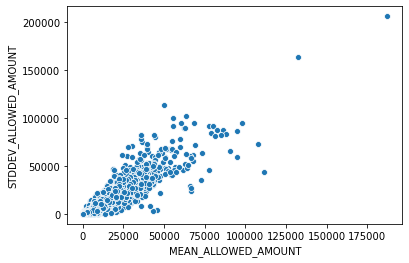

In [18]:
#plot stddev vs mean
ax = sns.scatterplot(y='STDDEV_ALLOWED_AMOUNT', x='MEAN_ALLOWED_AMOUNT', data=aa_trim_std_df)


In [ ]:
temp_df.columns

In [ ]:
px_reg_df.head()

In [ ]:
enet_coef_results

## Inspect Data

### Check to see if enhanced allowed amounts and allowed amounts distribution similarly

In [25]:
#basic stats for enhanced_allowed_amount
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=aa_enh_db)

Output()

In [26]:
#basic stats for allowed_amount
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=aa_db)

Output()

#### Note:  
Distributions similar, but all aa database has higher median, 95th, max values. 

### Check on percentage of encounters with allowed amounts

In [22]:
#basic stats for enhanced_allowed_amount
temp_select_statement=f"""select (select count(distinct encounter_key) 
  from """ + aa_enh_db + f"""where allowed_amount is NULL)/count(distinct encounter_key)
  as allowed_amount_fill_rate from""" + aa_enh_db 

pull_snfdb(select_statement=temp_select_statement)
    

Output()

#### Note:  
High fill rate

### TO DO: Check on difference between distributions between allowed amounts and all encounters

### Summarize allowed amounts by procedure

In [62]:
#basic stats for enhanced_allowed_amount

temp_select_statement=f""" select procedure
        , procedure_description
        ,count(distinct encounter_key) as count_ekey
        ,count(line_charge) as count_lc
        ,avg(line_charge::float) as average_lc
        ,count(total_claim_charge_amount) as count_tcca
        ,avg(total_claim_charge_amount::float) as average_tcca
        ,count(ALLOWED_AMOUNT) as count_aa
        ,stddev(ALLOWED_AMOUNT) as stddev_aa
        ,min(ALLOWED_AMOUNT::float) as min_aa
        ,avg(ALLOWED_AMOUNT::float) as average_aa
        ,median(ALLOWED_AMOUNT::float) as median_aa
         ,max(ALLOWED_AMOUNT::float) as max_aa
      from """ + aa_enh_db_001pct
temp_select_statement+=f""" where procedure is not NULL"""
temp_select_statement+=f""" group by procedure, procedure_description"""
temp_select_statement+=f""" order by count_aa DESC"""

px_proc_summary=pull_snfdb(select_statement=temp_select_statement, diag=False)

In [63]:
px_proc_summary["AA_EKEY_PCT"]=px_proc_summary["COUNT_AA"]/px_proc_summary["COUNT_EKEY"]
px_proc_summary["AA_LC"]=px_proc_summary["AVERAGE_AA"]/px_proc_summary["AVERAGE_LC"]
px_proc_summary["AA_TCCA"]=px_proc_summary["AVERAGE_AA"]/px_proc_summary["AVERAGE_TCCA"]

In [68]:
px_proc_summary

Output()

* Average AA vs STDDEV AA-roughly proportional
* Average AA vs AVG LC-not proportional
* Average AA vs AVG TCCA-def not proportional

* fewer ekeys than amounts?
* difference between LC and AA
* AA as pct of TCCA

In [67]:
px_proc_summary[["PROCEDURE", "PROCEDURE_DESCRIPTION", "AA_EKEY_PCT", "AA_LC", "AA_TCCA"]].describe()

Output()

### h2o Test

In [35]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_252"; OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09); OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn80m47b2
  JVM stdout: /tmp/tmpn80m47b2/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmpn80m47b2/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_jovyan_fho28m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.20 Gb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


In [45]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=1800, seed=1)
trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train ], axis=1))
testH2o=h2o.H2OFrame(pd.concat([y_test,X_test], axis=1))
aml.train(x=xNames.tolist(), y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
20:04:49.363: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [53]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20200923_200449,0.0538497,0.232055,0.0538497,0.0430717,nan
StackedEnsemble_AllModels_AutoML_20200923_200449,0.0550182,0.23456,0.0550182,0.0428493,nan
GLM_1_AutoML_20200923_200449,0.0978393,0.312793,0.0978393,0.0424971,nan
XGBoost_3_AutoML_20200923_200449,0.116541,0.341382,0.116541,0.190801,nan
XGBoost_1_AutoML_20200923_200449,0.131677,0.362873,0.131677,0.190306,nan
XGBoost_2_AutoML_20200923_200449,0.135456,0.368044,0.135456,0.19163,nan


In [54]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20200923_200449

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.018456219041449878
RMSE: 0.1358536677511869
MAE: 0.042277732369016406
RMSLE: NaN
R^2: 0.7197785648808512
Mean Residual Deviance: 0.018456219041449878
Null degrees of freedom: 9915
Residual degrees of freedom: 9913
Null deviance: 653.0973483337377
Residual deviance: 183.011868015017
AIC: -11439.792181489584

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.053849718728594155
RMSE: 0.23205542167463822
MAE: 0.04307168691397011
RMSLE: NaN
R^2: 0.4538492567503153
Mean Residual Deviance: 0.053849718728594155
Null degrees of freedom: 24999
Residual degrees of freedom: 24997
Null deviance: 2464.965925137148
Residual deviance: 1346.2429682148538
AIC: -2084.025805569242

ModelMetricsRegressionGLM: stackedensemble
** Report

### Old Code (for review)

In [34]:
coefDF

,coef,valCoefs
0,STATE_AK,0.000000
1,STATE_AL,0.000000
2,STATE_AR,-0.000000
3,STATE_AZ,-0.000000
4,STATE_CA,-0.000000
...,...,...
4938,PAYER_KH_ID_IMPUTE_FLAG_INT,-0.000000
4939,SOURCE_ROWLEY_INT,0.000000
4940,SOURCE_FLEMINGSALK_INT,-0.001911
4941,SOURCE_FLEMINGPESO_INT,0.008045


In [9]:
temp_df.head().T

,0,1,2,3,4
ENCOUNTER_KEY,711a2cae252a3cd14e259a8748c527b723b17fcf,621953566ec23be5fb06d0a84f39ed2678342982,be44423c90b2d044d20c053c6e5f1cf6ef17dacc,35abd0a59f6318ae8e258fc9fde05a34827e532d,6bacbb539ae0e2aae2f0cb72c13e1891d8326d2b
ALLOWED_AMOUNT,70.71,9.44,97.6,4.98,141
PROCEDURE,97597,73030,W1793,81025,99213
PROCEDURE_DESCRIPTION,Removal of tissue from wounds per session,"X-ray of shoulder, minimum of 2 views",None,Urine pregnancy test,Established patient office or other outpatient...
PATIENT_STATE,NJ,NY,PA,WI,FL
TOTAL_CLAIM_CHARGE_AMOUNT,401.28,12,97.6,0.47,141
PAYER_KH_ID,67,309,82,44,195
PAYER_KH_ID_IMPUTE_FLAG,False,False,False,False,True
SOURCE_ROWLEY,True,True,False,True,False
SOURCE_FLEMINGSALK,False,False,False,False,True


In [10]:
temp_df_5p_trim=temp_df[(temp_df.ALLOWED_AMOUNT>temp_df.PERCENTILE_5) & 
                      (temp_df.ALLOWED_AMOUNT<temp_df.PERCENTILE_95)]
temp_df_10p_trim=temp_df[(temp_df.ALLOWED_AMOUNT>temp_df.PERCENTILE_10) & 
                      (temp_df.ALLOWED_AMOUNT<temp_df.PERCENTILE_90)]

In [21]:
print(temp_df.shape)
print(temp_df_5p_trim.shape)
print(temp_df_10p_trim.shape)

(1000, 24)
(905, 24)
(807, 24)


In [22]:
print(np.mean(temp_df.ALLOWED_AMOUNT))
print(np.mean(temp_df_5p_trim.ALLOWED_AMOUNT))
print(np.mean(temp_df_10p_trim.ALLOWED_AMOUNT))

123.76563
107.21719337016575
105.97517967781909


In [23]:
print(np.median(temp_df.ALLOWED_AMOUNT))
print(np.median(temp_df_5p_trim.ALLOWED_AMOUNT))
print(np.median(temp_df_10p_trim.ALLOWED_AMOUNT))

56.120000000000005
53.52
52.99


In [24]:
print(np.std(temp_df.ALLOWED_AMOUNT))
print(np.std(temp_df_5p_trim.ALLOWED_AMOUNT))
print(np.std(temp_df_10p_trim.ALLOWED_AMOUNT))


297.9945169740596
257.67671269322733
252.65308179881725


In [25]:
temp_df_proc_summ=temp_df.groupby(['PROCEDURE']).agg(
                      {'ALLOWED_AMOUNT':['mean','std','median']}).reset_index()
temp_df_proc_summ.columns = ['procedure','mean','std','median']
temp_df_proc_summ.reindex(columns=sorted(temp_df_proc_summ.columns))
temp_df_proc_5p_summ=temp_df_5p_trim.groupby(['PROCEDURE']).agg(
                      {'ALLOWED_AMOUNT':['mean','std','median']}).reset_index()
temp_df_proc_5p_summ.columns = ['procedure','mean','std','median']
temp_df_proc_5p_summ.reindex(columns=sorted(temp_df_proc_5p_summ.columns))
temp_df_proc_10p_summ=temp_df_10p_trim.groupby(['PROCEDURE']).agg(
                      {'ALLOWED_AMOUNT':['mean','std','median']}).reset_index()
temp_df_proc_10p_summ.columns = ['procedure','mean','std','median']
temp_df_proc_10p_summ.reindex(columns=sorted(temp_df_proc_10p_summ.columns))

,mean,median,procedure,std
0,144.00,144.00,00400,NaN
1,1.77,1.77,00409120703,NaN
2,133.18,133.18,00731,NaN
3,129.86,129.86,00811,NaN
4,762.47,762.47,00840,NaN
...,...,...,...,...
390,54.88,54.88,T4526,NaN
391,27.50,27.50,V2100,NaN
392,69.00,69.00,V2784,NaN
393,136.64,136.64,W1793,55.210897


In [26]:
temp_df_proc_summ.describe()

,mean,std,median
count,462.000000,137.000000,462.000000
mean,164.983119,75.317934,159.822370
std,391.964318,186.849081,390.439282
min,0.010000,0.000000,0.010000
25%,18.847500,4.209424,17.212500
50%,58.260000,16.510682,57.590000
75%,157.194286,55.332822,145.780000
max,5021.280000,1202.911805,5021.280000


In [27]:
temp_df_proc_5p_summ.describe()


,mean,std,median
count,431.000000,126.000000,431.000000
mean,141.428814,41.763485,139.528434
std,351.559614,91.304633,351.562033
min,0.010000,0.000000,0.010000
25%,17.320000,3.627458,16.635000
50%,51.900000,11.713109,50.790000
75%,134.805000,37.631426,132.590000
max,5021.280000,686.409766,5021.280000


In [28]:
temp_df_proc_10p_summ.describe()

,mean,std,median
count,395.000000,112.000000,395.000000
mean,136.381217,37.129959,134.514873
std,339.914866,87.552800,339.612859
min,0.010000,0.000000,0.010000
25%,16.635000,2.837297,16.480000
50%,50.926667,8.227187,50.000000
75%,134.230000,23.422529,129.235000
max,5021.280000,686.409766,5021.280000


In [66]:
X_test.shape

(250, 621)

In [67]:
sqrt(mse(exp(yFit),exp(y_test)))

212.5308915231473

In [43]:
pred_mse=[]
pred_5p_trim_mse=[]
for __ in range(100):
    X_train, X_test= train_test_split(temp_df[yName],
                                                    test_size=0.25)
    X_trim_train, X_trim_test= train_test_split(temp_df_5p_trim[yName],
                                                    test_size=0.25)
    #basic model-no factors
    yFit=[np.mean(X_train)]*len(X_test)
    y_trim_Fit=[np.mean(X_trim_train)]*len(X_trim_test)
    pred_mse.extend([sqrt(mse(exp(yFit),exp(X_test)))])
    pred_5p_trim_mse.extend([sqrt(mse(exp(y_trim_Fit),exp(X_trim_test)))])
    


In [44]:
np.mean(pred_mse)

297.930299668922

In [ ]:
np.mean(pred_5p_trim_mse)

In [ ]:
exp()

In [ ]:
[np.exp(np.mean(X_train))]*len(X_test)

In [ ]:
resid_df=pd.DataFrame({"x":np.exp(X_test["LOG_ALLOWED_AMOUNT"]), "y":np.exp(np.mean(X_train["LOG_ALLOWED_AMOUNT"]))})
resid_df2=pd.DataFrame({"x":X_test["LOG_ALLOWED_AMOUNT"], "y":np.mean(X_train["LOG_ALLOWED_AMOUNT"])})

In [ ]:
resid_df["SE"]=(resid_df.x-resid_df.y)**2

In [ ]:
resid_df2["SE"]=(resid_df2.x-resid_df2.y)**2
resid_df2["ESE"]=np.exp((resid_df2.x-resid_df2.y)**2)

In [ ]:
np.sqrt(np.mean(resid_df.SE))

In [ ]:
np.exp(np.sqrt(np.mean(resid_df2.SE)))

In [ ]:
temp_df.loc[993]

In [ ]:
resid_df

In [ ]:
resid_df2

In [68]:
coefDF=pd.DataFrame({"coef":X_test.columns.values, "valCoefs": eNetReg.coef_})
coefDF=coefDF[coefDF.valCoefs.values!=0]
print(coefDF.sort_values(by=['valCoefs'],ascending=False))

                coef  valCoefs
418  PROCEDURE_93458  3.275959
396  PROCEDURE_90999  2.932817
162  PROCEDURE_01480  2.666378
230  PROCEDURE_70450  2.524007
564  PROCEDURE_J0178  2.518099
..               ...       ...
572  PROCEDURE_J1200 -3.240034
585  PROCEDURE_J7620 -4.095475
185  PROCEDURE_1160F -4.448883
182  PROCEDURE_1125F -6.231344
184  PROCEDURE_1159F -6.797520

[438 rows x 2 columns]


In [73]:
coefDF.coef.values

array(['STATE_AK', 'STATE_AL', 'STATE_AZ', 'STATE_CA', 'STATE_CO',
       'STATE_CT', 'STATE_DC', 'STATE_DE', 'STATE_FL', 'STATE_GA',
       'STATE_HI', 'STATE_IA', 'STATE_ID', 'STATE_IL', 'STATE_IN',
       'STATE_KS', 'STATE_KY', 'STATE_LA', 'STATE_MD', 'STATE_ME',
       'STATE_MI', 'STATE_MN', 'STATE_MO', 'STATE_NC', 'STATE_ND',
       'STATE_NE', 'STATE_NH', 'STATE_NJ', 'STATE_NY', 'STATE_PA',
       'STATE_SC', 'STATE_TX', 'STATE_UT', 'STATE_VA', 'STATE_WA',
       'STATE_WI', 'STATE_WV', 'STATE_WY', 'PAYER_1', 'PAYER_102',
       'PAYER_103', 'PAYER_108', 'PAYER_11', 'PAYER_129', 'PAYER_134',
       'PAYER_14', 'PAYER_143', 'PAYER_144', 'PAYER_148', 'PAYER_157',
       'PAYER_16', 'PAYER_161', 'PAYER_164', 'PAYER_165', 'PAYER_17',
       'PAYER_18', 'PAYER_181', 'PAYER_182', 'PAYER_184', 'PAYER_186',
       'PAYER_189', 'PAYER_192', 'PAYER_21', 'PAYER_214', 'PAYER_216',
       'PAYER_221', 'PAYER_225', 'PAYER_241', 'PAYER_243', 'PAYER_250',
       'PAYER_251', 'PAYER_260', 'PAYE

In [70]:
coefDF.T

,0,1,3,4,5,6,7,8,9,10,...,607,609,610,611,612,615,616,617,618,620
coef,STATE_AK,STATE_AL,STATE_AZ,STATE_CA,STATE_CO,STATE_CT,STATE_DC,STATE_DE,STATE_FL,STATE_GA,...,PROCEDURE_T2042,PROCEDURE_T4530,PROCEDURE_T4535,PROCEDURE_V2100,PROCEDURE_V2784,PROCEDURE_W9047,PAYER_KH_ID_IMPUTE_FLAG_INT,SOURCE_ROWLEY_INT,SOURCE_FLEMINGSALK_INT,SOURCE_FLEMINGNIGHTINGALE_INT
valCoefs,0.49417,-0.276112,-0.0739494,-0.113058,0.102492,0.132339,0.0105948,-0.270907,-0.121271,-0.115809,...,0.249168,1.17236,-0.522055,-0.233765,0.028717,0.74995,-0.108201,-0.0399801,-0.211195,-0.0821781
